# 1. 导入相关的包

In [1]:
import torch.nn as nn
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import json
from PIL import Image

In [2]:
# 设置随机种子
torch.manual_seed(42)
# random.seed(42)
# np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. 下载数据集并预处理

In [3]:
# 预处理方式
transform = transforms.Compose([
    transforms.ToTensor(),                           
    transforms.Normalize((0.1307,), (0.3081,))    
])

# 获取数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)   # 60000
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)   # 10000

# 定义数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)  # 469
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)    # 测试集不用划分和打乱

In [4]:
class_indices = train_dataset.class_to_idx
json_str = json.dumps(class_indices, indent=4)
with open('class_indices.json', 'w') as f:
    f.write(json_str)

# 3. 搭建 CNN 模型

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 卷积块 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 卷积块 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接层 1
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 4 * 4, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 输出层
        self.fc2 = nn.Linear(64, 10)

    # 前向传播
    def forward(self, x):   
        x = self.conv1(x)   
        x = self.conv2(x)   
        x = x.view(x.size(0), -1)   
        x = self.fc1(x)     
        x = self.fc2(x)     
        return x

# 4. 模型训练

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
num_epochs = 50
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

# 训练（测试）准确率与损失
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_test_acc = 0.0  # 最佳测试准确率


start_time = time.time()

# 开始训练
for epoch in range(num_epochs):
    # 训练模式
    model.train()

    for i, (inputs, labels) in enumerate(train_loader):  # i from 0 to 469
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每隔 100 个 batch 记录一次训练损失和准确率，并进行测试
        if (i + 1) % 100 == 0:
            # 计算训练损失和准确率
            train_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct = (predicted == labels).sum().item()
            train_total = labels.size(0)
            train_acc = 100.0 * train_correct / train_total

            # 将训练损失和准确率记录到列表
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)

            # 测试模式
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for j, (inputs, labels) in enumerate(test_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # 累加测试损失和正确预测数
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    test_correct += (predicted == labels).sum().item()
                    test_total += labels.size(0)

            # 计算测试集的平均损失和准确率
            avg_test_loss = test_loss / len(test_loader)
            test_acc = 100.0 * test_correct / test_total
            test_acc_list.append(test_acc)
            test_loss_list.append(avg_test_loss)

            # 保持最佳模型
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                torch.save(model.state_dict(), 'best_model.pth')

            # 打印当前结果
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%, "
                  f"Lr: {optimizer.param_groups[0]['lr']:.6f}")

            # 恢复训练模式
            model.train()

            # 调整学习率
            # scheduler.step()

print(f"Best Test Acc: {best_test_acc:.2f}%")

# 保持最终模型
torch.save(model.state_dict(), 'last_model.pth')

end_time = time.time()

print(f"Taken time: {(end_time - start_time) // 60:.0f} min {(end_time - start_time) % 60:.0f} sec")

Epoch [1/50], Step [100/469], Train Loss: 2.2373, Train Acc: 27.34%, Test Loss: 2.2217, Test Acc: 32.50%, Lr: 0.001000
Epoch [1/50], Step [200/469], Train Loss: 1.7424, Train Acc: 53.12%, Test Loss: 1.7247, Test Acc: 64.81%, Lr: 0.001000
Epoch [1/50], Step [300/469], Train Loss: 0.7042, Train Acc: 76.56%, Test Loss: 0.6429, Test Acc: 83.22%, Lr: 0.001000
Epoch [1/50], Step [400/469], Train Loss: 0.4504, Train Acc: 87.50%, Test Loss: 0.4367, Test Acc: 87.78%, Lr: 0.001000
Epoch [2/50], Step [100/469], Train Loss: 0.3572, Train Acc: 88.28%, Test Loss: 0.3234, Test Acc: 90.77%, Lr: 0.001000
Epoch [2/50], Step [200/469], Train Loss: 0.4022, Train Acc: 86.72%, Test Loss: 0.2887, Test Acc: 91.67%, Lr: 0.001000
Epoch [2/50], Step [300/469], Train Loss: 0.3166, Train Acc: 90.62%, Test Loss: 0.2550, Test Acc: 92.44%, Lr: 0.001000
Epoch [2/50], Step [400/469], Train Loss: 0.3072, Train Acc: 89.84%, Test Loss: 0.2439, Test Acc: 92.67%, Lr: 0.001000
Epoch [3/50], Step [100/469], Train Loss: 0.2826

# 5. 结果可视化

In [7]:
def plot_loss(train_loss_list, test_loss_list):
    plt.plot(range(len(train_loss_list)), train_loss_list,'darkorange')
    plt.plot(range(len(test_loss_list)), test_loss_list,'turquoise')
    plt.legend(['Train Loss','Test Loss'], fontsize=14, loc='best')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid()
    plt.savefig('loss.png')
    plt.show()

def plot_acc(train_acc_list, test_acc_list):
    plt.plot(range(len(train_acc_list)), train_acc_list, 'darkorange')
    plt.plot(range(len(test_acc_list)), test_acc_list, 'turquoise')
    plt.legend(['Train Accuracy',' Test Accuracy'], fontsize=14, loc='best')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid()
    plt.savefig('accuracy.png')
    plt.show()   

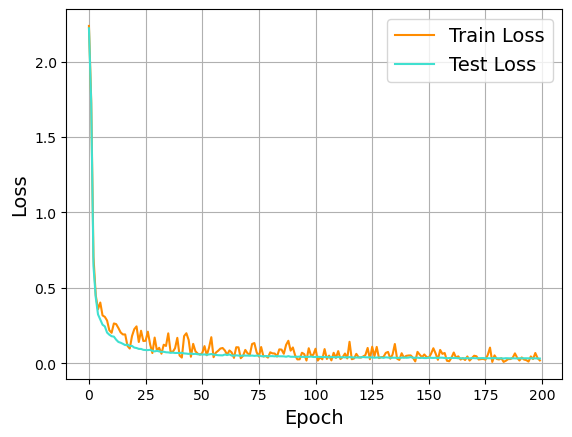

In [8]:
plot_loss(train_loss_list, test_loss_list)

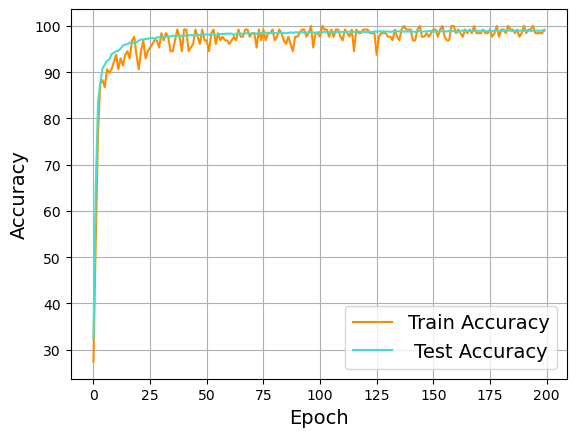

In [9]:
plot_acc(train_acc_list, test_acc_list)

# 6. 模型预测

In [6]:
# 导入模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))

<All keys matched successfully>

In [8]:
# 预处理方式
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),                           
    transforms.Normalize((0.1307,), (0.3081,))    
])

# 从 json 文件读取类别标签
with open("./class_indices.json", "r") as f:
    class_indices = json.load(f)

class_indices = {v: k for k, v in class_indices.items()}
print(class_indices)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


In [13]:
# 读取图片
img = Image.open('./images/1.png').convert('L')    
img = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(img.to(device))
    _, predicted = torch.max(output, 1) 
    pred_prob = torch.softmax(output, dim=1).tolist()[0]
    pred_prob = [round(i, 4) for i in pred_prob]         

print(f"预测概率: {pred_prob}")
print(f"预测结果: {class_indices[predicted.item()]}")

预测概率: [0.0, 0.9986, 0.0, 0.0, 0.0004, 0.0, 0.0001, 0.0003, 0.0004, 0.0]
预测结果: 1 - one


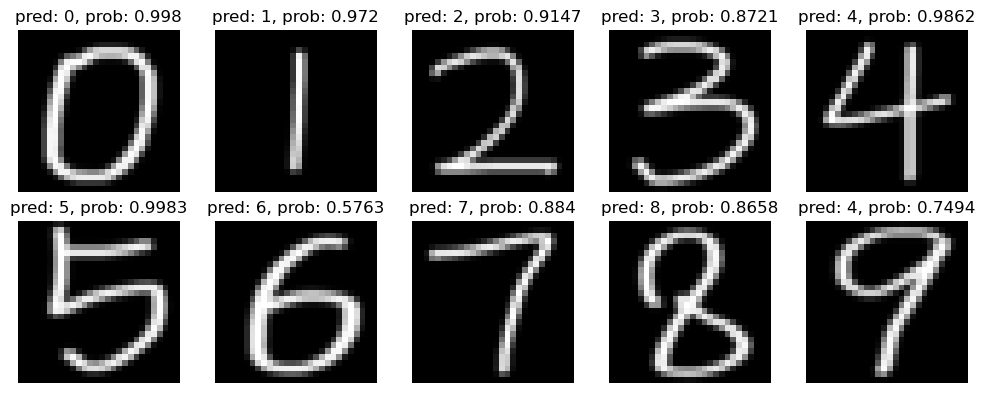

In [17]:
"""以上为单张图像预测 下面实现 10 张图像预测"""
plt.figure(figsize=(10, 4))

for i in range(10):
    img = Image.open(f'./images/{i}.png').convert('L')
    img = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img.to(device))
        _, predicted = torch.max(output, 1)
        pred_prob = torch.softmax(output, dim=1).tolist()[0]
        pred_prob = [round(i, 4) for i in pred_prob]    
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(f'pred: {predicted.item()}, prob: {pred_prob[predicted.item()]}')
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('result.png')
plt.show()

# 7. 卷积核可视化

In [7]:
# 初始化字典
feature_map_block0 = {}
feature_map_block1 = {}

# 注册 hook 函数
def forward_hook0(module, input, output):
    feature_map_block0["input"] = input[0]  # [0] 取第一个元素 [something] -> something
    feature_map_block0["output"] = (
        output  # 不用 [0] 因为输入已经设置好为 1 个 故输出为 1 个
    )

def forward_hook1(module, input, output):
    feature_map_block1["input"] = input[0]
    feature_map_block1["output"] = output

In [9]:
# 测试一个样本输入 使用钩子函数查看卷积层输入输出
model.eval()  # 关闭 BN 很重要 否则不允许输入一个样本
model.conv1[0].register_forward_hook(forward_hook0)
model.conv2[0].register_forward_hook(forward_hook1)

# 用一个样本作为输入 测试
img = Image.open('./images/0.png').convert('L')    
img = transform(img).unsqueeze(0)

# 关闭反向传播 节省内存
with torch.no_grad():
    output = model(img.to(device))

# 第一个卷积层的输入、输出、特征图尺寸
print(feature_map_block0["input"].shape)
print(feature_map_block0["output"].shape)
print(feature_map_block0["output"][0][0].shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 8, 24, 24])
torch.Size([24, 24])


In [10]:
# 打印各个卷积层的输入输出特征图的大小
print(feature_map_block0["input"].shape, feature_map_block0["output"].shape)
print(feature_map_block1["input"].shape, feature_map_block1["output"].shape)

torch.Size([1, 1, 28, 28]) torch.Size([1, 8, 24, 24])
torch.Size([1, 8, 12, 12]) torch.Size([1, 16, 8, 8])


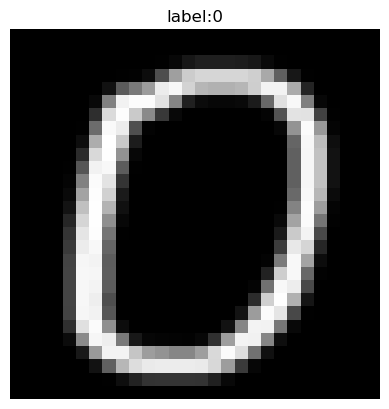

In [13]:
# 可视化输入样本
fig = plt.figure()
plt.tight_layout()
plt.imshow(
    img.cpu().reshape(28, 28), cmap="gray"
)  # 将图像张量移动到 CPU 因为 Matplotlib 只支持 CPU 张量
plt.title("label:0")
plt.axis("off")
plt.show()

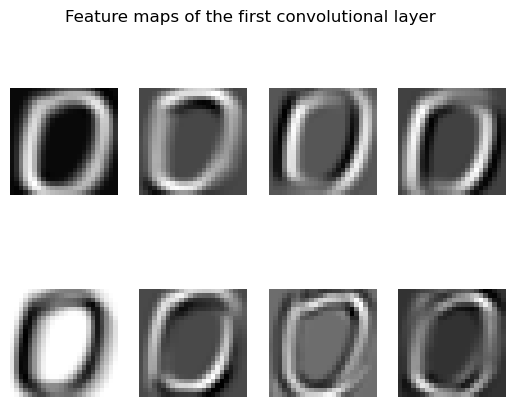

In [22]:
# 可视化第一个卷积层输出的特征图
plt.figure()
for i in range(8):
    # ['output'] -> [1, 8, 24, 24]
    # ['output'][0] -> [8, 24, 24]
    # ['output'][0][i] -> [24, 24]
    # Matplotlib 只支持显示 CPU 张量
    # detach() 用于从计算图中分离张量，防止反向传播时梯度计算错误
    # numpy() 用于将张量转换为 numpy 数组
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        feature_map_block0["output"][0][i].cpu().detach().numpy().reshape(24, 24),
        cmap="gray",
    )
    plt.axis("off")
plt.suptitle("Feature maps of the first convolutional layer")
plt.show()

In [23]:
print(model.conv1)
print("========================================================")
print(model.conv1[0])
print("========================================================")
print(model.conv1[0].weight)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
Parameter containing:
tensor([[[[ 0.3870,  0.4512,  0.1189,  0.1685, -0.1455],
          [ 0.2540,  0.3283,  0.5345,  0.3660, -0.0965],
          [ 0.3724,  0.5548,  0.7104,  0.3722,  0.3080],
          [ 0.0174,  0.4397,  0.3792,  0.1867,  0.2655],
          [-0.2505,  0.0084,  0.0849,  0.2981, -0.0239]]],


        [[[-0.1045, -0.1131, -0.2420, -0.1820, -0.4232],
          [ 0.2020, -0.1913,  0.0648, -0.1400, -0.2183],
          [ 0.2876,  0.2533,  0.3787,  0.1658,  0.0938],
          [ 0.2116,  0.2469,  0.4890,  0.5821,  0.4900],
          [-0.1124,  0.2235,  0.1795,  0.2816,  0.0952]]],


        [[[-0.1794,  0.0874,  0.0712,  0.2536,  0.0108],
          [ 0.1206,  0.2873,  0.2257,  0.1456, -0.2980],
          [ 0.1521,  0.2544,  0.2826, -0.1891, -0.1647],
          [ 0.13

In [17]:
print(model.conv1[0].weight.shape)
print(model.conv1[0].weight[0].shape)

torch.Size([8, 1, 5, 5])
torch.Size([1, 5, 5])


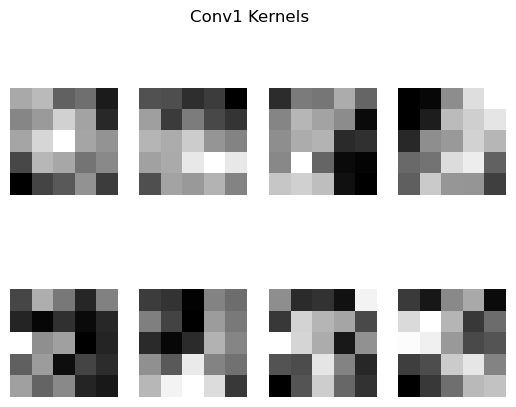

In [18]:
# 可视化第一个卷积层的卷积核（权重）
fig = plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    # model.conv1[0].weight -> [8, 1, 5, 5]
    # model.conv1[0].weight[i] -> [1, 5, 5]
    plt.imshow(
        model.conv1[0].weight[i].cpu().detach().numpy().reshape(5, 5), cmap="gray"
    )
    plt.axis("off")
plt.suptitle("Conv1 Kernels")
plt.show()

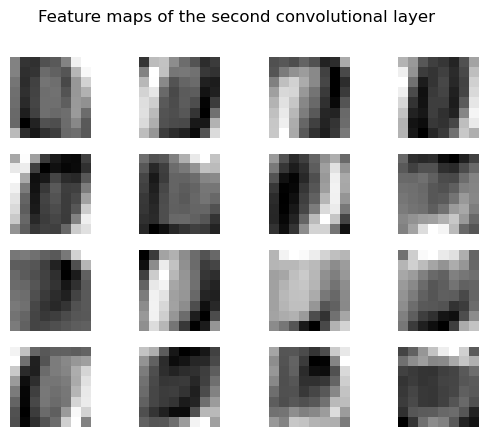

In [24]:
# 可视化第二个卷积层输出的特征图
plt.figure()
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(
        feature_map_block1["output"][0][i].cpu().detach().numpy().reshape(8, 8),
        cmap="gray",
    )
    plt.axis("off")
plt.suptitle("Feature maps of the second convolutional layer")
plt.show()

In [25]:
print(model.conv2[0].weight.shape)
print(model.conv2[0].weight[0].shape)  # 想办法把 16 这个维度给去掉
print(model.conv2[0].weight[:, 0, :, :].shape)

torch.Size([16, 8, 5, 5])
torch.Size([8, 5, 5])
torch.Size([16, 5, 5])


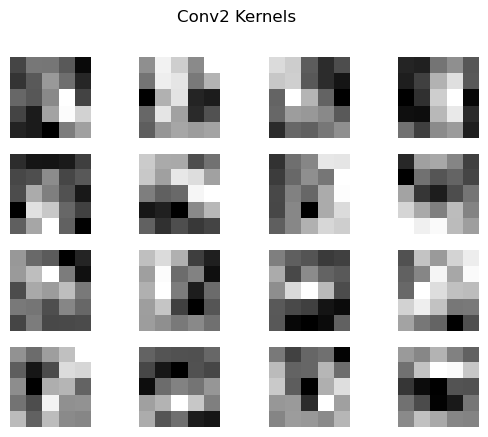

In [27]:
# 可视化第二个卷积层的卷积核（权重）
fig = plt.figure()
for i, j in enumerate(model.conv2[0].weight[:, 0, :, :], 0):  # 去掉一个维度
    # i 从 0 开始
    # j 才是真正的遍历
    plt.subplot(4, 4, i + 1)
    plt.imshow(j.cpu().detach().numpy().reshape(5, 5), cmap="gray")
    plt.axis("off")
plt.suptitle("Conv2 Kernels")
plt.show()